In [2]:
!nvidia-smi

/usr/bin/sh: 1: nvidia-smi: not found


In [1]:
from domino import DominoSlicer
import numpy as np
import sklearn
import pandas as pd
sklearn.__version__

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import torch
import os

In [3]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
outpath = os.path.join("outputs", "places8_bedroom_childs_room")
os.makedirs(outpath, mode=777, exist_ok=True)


In [4]:
def gen_tsne(predict, clip_emb, plot_n = None, n = 5):
    cluster_label = np.argmax(predict, axis = -1)
    label, counts = np.unique(cluster_label, return_counts = True)
    print(label, counts)
    counts = min(counts)

    if plot_n != None:
        counts = plot_n
    random.seed(42)
    
    filter_0 = random.sample(list(np.where(cluster_label == 0)[0]), counts)
    filter_1 = random.sample(list(np.where(cluster_label == 1)[0]), counts)
    filtered_clip_embeds = clip_emb[filter_0]
    filtered_labels = cluster_label[filter_0]
    filtered_clip_embeds = np.concatenate((filtered_clip_embeds, clip_emb[filter_1]))
    filtered_labels = np.concatenate((filtered_labels, cluster_label[filter_1]))
    if n == 3:
        filter_2 = random.sample(list(np.where(cluster_label == 2)[0]), counts)
        filtered_clip_embeds = np.concatenate((filtered_clip_embeds, clip_emb[filter_2]))
        filtered_labels = np.concatenate((filtered_labels, cluster_label[filter_2]))

    X_embedded = TSNE(n_components=2, learning_rate='auto', 
                      init='random', perplexity=3).fit_transform(filtered_clip_embeds)
    X_embedded.shape

    tsne_result_df = pd.DataFrame({'component1': X_embedded[:,0],
                                   'component2': X_embedded[:,1],
                                   'label': filtered_labels})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x = 'component1',
                    y = 'component2',
                    hue = 'label',
                    data = tsne_result_df, ax = ax, sizes = 5)
    lim = (X_embedded.min() - 5, X_embedded.max() + 5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.0)

## 2 classes | 3 slices

In [5]:
slicer = DominoSlicer(
    y_log_likelihood_weight=5,
    y_hat_log_likelihood_weight=5,
    n_mixture_components=100,
    n_slices=3,
    confusion_noise= 0.001,
    random_state=42)
slicer.get_params()

{'n_slices': 3,
 'covariance_type': 'diag',
 'n_pca_components': 128,
 'n_mixture_components': 100,
 'init_params': 'kmeans',
 'confusion_noise': 0.001,
 'y_log_likelihood_weight': 5,
 'y_hat_log_likelihood_weight': 5,
 'max_iter': 100,
 'random_state': 42}

## class 1: bedroom | 3 slices

In [13]:
places8_clip_emd = "data/places8_image_features_clip_class_1.npy"
places8_image_softmax = "data/places8_image_features_resnet50_softmax_class_1.npy"
places8_targets = "data/places8_image_targets.npy"
clip_emb_1 = np.load(places8_clip_emd)
preds_softmax_1 = np.load(places8_image_softmax)
places8_targets = np.load(places8_targets)
places8_targets_1 = places8_targets[np.where(places8_targets==1)[0]]

# filter softmax per index 1
preds_softmax_1 = preds_softmax_1[:, :2]
print("Data with class 1:")
print(f"Embed shape {clip_emb_1.shape} | target shape {places8_targets_1.shape} | preds softmax shape {preds_softmax_1.shape}")

Data with class 1:
Embed shape (100012, 512) | target shape (100012,) | preds softmax shape (100012, 2)


Data with class 1:
Embed shape (100012, 512) | target shape (100012,) | preds softmax shape (100012, 2)


 28%|████████████████████████████████████████████████▋                                                                                                                             | 28/100 [00:45<01:56,  1.61s/it]


[0 1 2] [35722 62738  1552]
100012


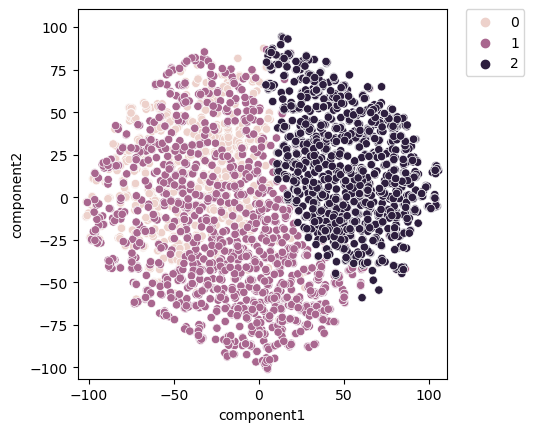

In [26]:
_ = slicer.fit(embeddings = clip_emb_1, targets = places8_targets_1, pred_probs = preds_softmax_1)
predict = slicer.predict(embeddings = clip_emb_1, targets = places8_targets_1, pred_probs = preds_softmax_1)
gen_tsne(predict, clip_emb_1, n=3)
df = pd.DataFrame(predict, columns=['group_0', 'group_1', 'group_2'])
print(len(df))
df.to_csv(f"{outpath}/class1_bedroom_3slices_otherclassessoftmax.csv", index = False, encoding='utf-8')

## class 2: child's room | 3 slices

Data with class 2
Embed shape (41849, 512) | target shape (41849,) | preds softmax shape (41849, 3)


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 50/100 [00:19<00:19,  2.56it/s]


[0 1 2] [ 6000 10622 25227]
41849


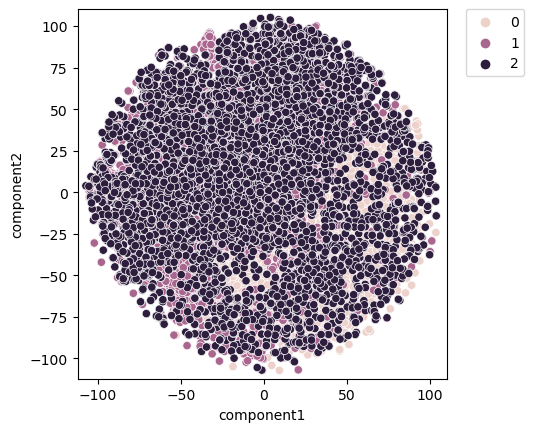

In [27]:
places8_clip_emd = "data/places8_image_features_clip_class_2.npy"
places8_image_softmax = "data/places8_image_features_resnet50_softmax_class_2.npy"
places8_targets = "data/places8_image_targets.npy"

places8_targets = np.load(places8_targets)
clip_emb_2 = np.load(places8_clip_emd)
preds_softmax_2 = np.load(places8_image_softmax)
places8_targets_2 = places8_targets[np.where(places8_targets == 2)[0]]
# places8_targets_2 = np.ones(places8_targets_2.shape, dtype = int)

# filter softmax per index 2
preds_softmax_2 = preds_softmax_2[:, :3]

print("Data with class 2")
print(f"Embed shape {clip_emb_2.shape} | target shape {places8_targets_2.shape} | preds softmax shape {preds_softmax_2.shape}")
_ = slicer.fit(embeddings = clip_emb_2, targets = places8_targets_2, pred_probs = preds_softmax_2)
predict = slicer.predict(embeddings = clip_emb_2, targets = places8_targets_2, pred_probs = preds_softmax_2)
gen_tsne(predict, clip_emb_2, n=3)
df = pd.DataFrame(predict, columns=['group_0', 'group_1', 'group_2'])
print(len(df))
df.to_csv(f"{outpath}/class2_childs_room_3slices_otherclassessoftmax.csv", index = False, encoding='utf-8')


In [26]:
places8_clip_emd_1 = "data/places8_image_features_clip_class_1.npy"
places8_image_softmax_1 = "data/places8_image_features_resnet50_softmax_class_1.npy"
places8_clip_emd_2 = "data/places8_image_features_clip_class_2.npy"
places8_image_softmax_2 = "data/places8_image_features_resnet50_softmax_class_2.npy"
places8_targets = "data/places8_image_targets.npy"

clip_emb_1 = np.load(places8_clip_emd_1)
clip_emb_2 = np.load(places8_clip_emd_2)
preds_softmax_1 = np.load(places8_image_softmax_1)
preds_softmax_2 = np.load(places8_image_softmax_2)
# filter softmax per index 1
# preds_softmax = preds_softmax_1[:, 1:3]

places8_targets = np.load(places8_targets)
places8_targets_1 = places8_targets[np.where(places8_targets==1)[0]]
places8_targets_2 = places8_targets[np.where(places8_targets==2)[0]]

clip_embeds = np.concatenate([clip_emb_1, clip_emb_2])
preds_softmax = np.concatenate([preds_softmax_1[:,:3], preds_softmax_2[:, :3]])
targets = np.concatenate([places8_targets_1, places8_targets_2])



print("Data with class 1:")
print(f"Embed shape {clip_emb_1.shape} | target shape {places8_targets_1.shape} | preds softmax shape {preds_softmax_1.shape}")
print(f"Embed shape {clip_emb_2.shape} | target shape {places8_targets_2.shape} | preds softmax shape {preds_softmax_2.shape}")
print(f"Embed shape {clip_embeds.shape} | target shape {targets.shape} | preds softmax shape {preds_softmax.shape}")

Data with class 1:
Embed shape (100012, 512) | target shape (100012,) | preds softmax shape (100012, 8)
Embed shape (41849, 512) | target shape (41849,) | preds softmax shape (41849, 8)
Embed shape (141861, 512) | target shape (141861,) | preds softmax shape (141861, 3)


 34%|██████████████▎                           | 34/100 [00:55<01:47,  1.63s/it]


[0 1 2] [ 11329 100086  30446]
141861


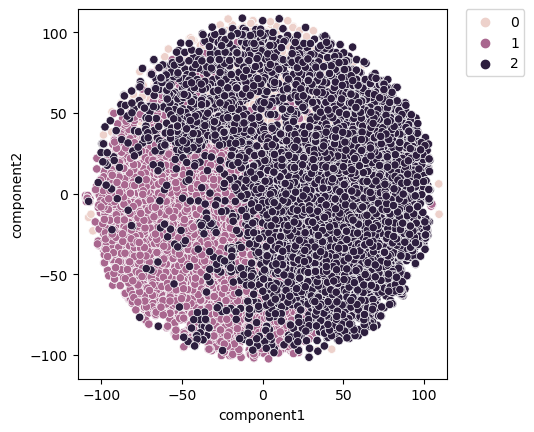

In [28]:
_ = slicer.fit(embeddings = clip_embeds, targets = targets, pred_probs = preds_softmax)
predict = slicer.predict(embeddings = clip_embeds, targets = targets, pred_probs = preds_softmax)
gen_tsne(predict, clip_embeds, n=3)
df = pd.DataFrame(predict, columns=['group_0', 'group_1', 'group_2'])
print(len(df))
df.to_csv(f"{outpath}/class2_childs_room_3slices_2classes_softmax.csv", index = False, encoding='utf-8')
